# Overview of Notebooks

* **[HAPI_01.ipynb - Basics](HAPI_01.ipynb) (this Notebook)**
* [HAPI_02.ipynb - Data structures](HAPI_02.ipynb)
* [HAPI_03.ipynb - Plotting](HAPI_03.ipynb)
* [HAPI_04.ipynb - Problems](HAPI_04.ipynb)

# Setup

We'll be using examples from the October 28, 2022 flare + CME event that started at 15:35 UTC and explore it from a variety of instruments.
  
First, we will import the HAPI libraries.  We'll repeat these calls in each example  so that you can try them in any order during this demo.  The basic import lines can be used in any Python code. 

In [4]:
from hapiclient import hapi
from hapiplot import hapiplot

The following are optional Jupyter Notebook specific configuration options

In [76]:
# Show Matplotlib plots in page instead of opening a window
%matplotlib inline 
# Have Matplotlib create vector (svg) instead of raster (png) images
%config InlineBackend.figure_formats = ['svg'] 

# Misc. configuration
import warnings
# See https://github.com/boto/boto3/issues/454 for an explanation.
warnings.simplefilter("ignore", ResourceWarning) # removes spurious Notebook warns

# Display documentation

A quick look at what built-in documentation the hapi client provides. The function `hapi` is the primary function that you will use. Note that it does not follow common Python conventions for function calls because the the number of non-keyword arguments is not fixed and the number of outputs varies depending on the input arguments.

In [65]:
from hapiclient import hapi
help(hapi)

Help on function hapi in module hapiclient.hapi:

hapi(*args, **kwargs)
    Request data from a HAPI server.
    
    Version: 0.2.3
    
    
    Examples
    ----------
    `Jupyter Notebook <https://colab.research.google.com/drive/11Zy99koiE90JKJ4u_KPTaEBMQFzbfU3P?usp=sharing>_`
    
    Parameters
    ----------
    server : str
        A string with the URL to a HAPI compliant server. (A HAPI URL
        always ends with "/hapi").
    dataset : str
        A string specifying a dataset from a `server`
    parameters: str
        A Comma-separated list of parameters in `dataset`
    start: str
        The start time of the requested data
    stop: str
        The end time of the requested data; end times are exclusive - the
        last data record returned by a HAPI server should have a timestamp
        before `start`.
    options : dict
    
            `logging` (False) - Log to console
    
            `cache` (True) - Save responses and processed responses in cachedir
    
  

# Get Data

The event started at 15:35UTC on Oct 28, 2022 with a [X1 Flare](https://www.spaceweatherlive.com/en/news/view/445/20211028-x1-solar-flare-with-a-major-cme.html) and an accompanying coronal mass ejection (CME). The CME was predicted to arrive [at Earth on Oct 30](https://www.swpc.noaa.gov/news/geomagnetic-storm-watch-effect-30-31-oct) and induce activity through Oct 31.  We will look at data fetched via HAPI for before, during, and after this event and see what patterns arise.

Instruments we'll use to start this demo include

* Solar wind compiled data using [OMNI](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018SW002113)

* Measurements [at L1](https://helionauts.org/t/ace-and-dscovr-data-types/389/8) (e.g. ACE, DISCOVR, WIND, ISEE-3), we'll use DSCOVER H0 mag and H1 plasma data from CDAWeb

* Near Earth (ISEE-1, IMP-8, Geotail, Cluster)

* Geomagnetic index K$_p$: ("_The Kp index is a measure of the disturbance of the geomagnetic field measured at Earth’s surface. The scale ranges from 0 to 9 with no units. A Kp of 3 or less is considered undisturbed, a Kp greater than 4 is considered storm conditions._")

During these examples, you'll also be offered a menu of other potential instruments to add in, including: 

## Example 1: OMNIWeb Solar Wind via CDAWeb

We will start by using HAPI to fetch the Dst index from the OMNIWeb (parameter name is `DST1800`) dataset and `Proton_AI1800` (Solar wind mag density/kinetic energy density), plus metadata, for Oct 25 through Dec 5.  

For this first example, `logging=True` is used so that you can see the steps that `hapi` is (or is not) taking; for production use, or to de-clutter the screen, you likely will choose to turn this off with `logging=False` (the default).

_Note `hapi` returns `data` as a NumPy array and `meta` as a Python dict_

In [71]:
## OMNIWeb data
from hapiclient import hapi

# The data server
server     = 'https://cdaweb.gsfc.nasa.gov/hapi'

# The data set
dataset    = 'OMNI2_H0_MRG1HR'

# Start and stop times
start      = '2021-11-25T00:00:00Z'
stop       = '2021-12-05T00:00:00Z'

# The HAPI convention is that parameters is a comma-separated list. Here we request two parameters.
parameters = 'DST1800,Proton_QI1800'

# Configuration options for the hapi function.
opts       = {'logging': True}

# Get parameter data. See section 5 for for information on getting available datasets and parameters
data, meta = hapi(server, dataset, parameters, start, stop, **opts)

hapi(): Running hapi.py version 0.2.3
hapi(): file directory = cdaweb.gsfc.nasa.gov_hapi
hapi(): Reading OMNI2_H0_MRG1HR_DST1800-Proton_QI1800_20211125T000000_20211205T000000.pkl
hapi(): Reading OMNI2_H0_MRG1HR_DST1800-Proton_QI1800_20211125T000000_20211205T000000.npy 


### Inspect metadata

The metadata is essential to track and recall what we are actually looking at.  Let's see what that data structure looks like for HAPI. The `meta` dict contains the same metadata that would be returned from a direct request. For example, to obtain metadata, the `hapi` function made a call to https://cdaweb.gsfc.nasa.gov/hapi/info?id=OMNI2_H0_MRG1HR, which contains the metadata for all parameters in the dataset `OMNI2_H0_MRG1HR`.

In [53]:
display(meta)

{'HAPI': '2.0',
 'status': {'code': 1200, 'message': 'OK'},
 'parameters': [{'name': 'Time',
   'type': 'isotime',
   'units': 'UTC',
   'length': 24,
   'fill': None},
  {'name': 'DST1800',
   'type': 'integer',
   'units': 'nT',
   'fill': '99999',
   'description': 'Dst - 1-hour Dst index (1963/001-2014/366), Provisional Dst (2015/001-2017/366), Quick-look Dst (2018/001-2022/094), from WDC Kyoto'},
  {'name': 'Proton_QI1800',
   'type': 'double',
   'units': ' ',
   'fill': '9.9999',
   'description': 'Solar wind (magnetic energy density)/(kinetic energy density)'}],
 'startDate': '1970-01-01T00:00:00Z',
 'stopDate': '2022-04-13T13:00:00Z',
 'resourceURL': 'https://cdaweb.gsfc.nasa.gov/misc/NotesO.html#OMNI2_H0_MRG1HR',
 'contact': 'J.H. King, N. Papitashvili @ ADNET, NASA GSFC',
 'x_server': 'https://cdaweb.gsfc.nasa.gov/hapi',
 'x_dataset': 'OMNI2_H0_MRG1HR',
 'x_parameters': 'DST1800,Proton_QI1800',
 'x_time.min': '2021-11-25T00:00:00Z',
 'x_time.max': '2021-12-05T00:00:00Z',
 'x

### Plot the data (using the `hapiplot` library).

We would expect to see some activity in the Oct 30-31 frame, as the CME reaches L1.

Here we will use the `hapiplot` library. Configuration options and demonstration of plotting data using other packages are covered in [HAPI_03.ipynb](HAPI_03.ipynb).

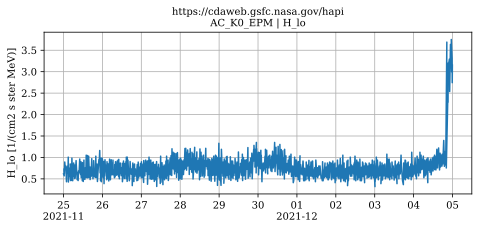

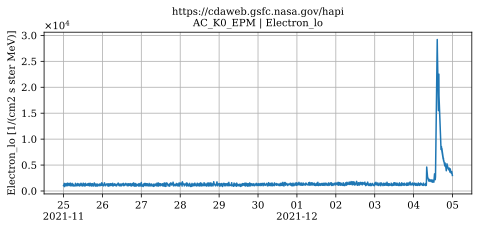

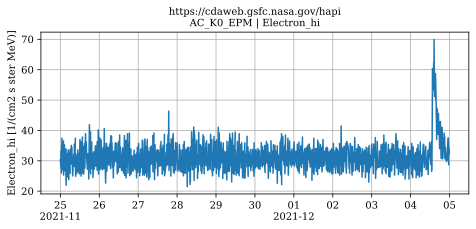

In [56]:
# Plot all parameters in the NumPy N-D array `data`.
from hapiplot import hapiplot
hapiplot(data, meta);

### Extract dates + one data item

Here is how to convert the HAPI timestamps into a Python `datetime` object, and also extract just one of the data parameters as a Numpy array.  We will print out the first five elements to verify this.

Additional details on working with the output of `hapi` are given in [HAPI_02.ipynb](HAPI_02.ipynb).

The HAPI standard is that all time values are represented as ISO8601 strings. The function `hapitime2datetime` can be used to convert these strings to Python `datetime` objects.

In [60]:
# Extract time values as datetime objects. See section 3 for more details.
from hapiclient import hapitime2datetime

dateTimes = hapitime2datetime(data['Time'])
print("\nFirst values of Time parameter = ")
display(data['Time'][0:5])

dateTimes = hapitime2datetime(data['Time'])
print("\nFirst values fdatetimes = ")
display(dateTimes[0:5])

# Extract one of the parameters as NumPy array
BGSEc = data['DST1800']
print("\nDST1800 =")
display(BGSEc[0:5])



First values of Time parameter = 


array([b'2021-11-25T00:30:00.000Z', b'2021-11-25T01:30:00.000Z',
       b'2021-11-25T02:30:00.000Z', b'2021-11-25T03:30:00.000Z',
       b'2021-11-25T04:30:00.000Z'], dtype='|S24')


First values of Time parameter represented as datetimes = 


array([datetime.datetime(2021, 11, 25, 0, 30, tzinfo=<UTC>),
       datetime.datetime(2021, 11, 25, 1, 30, tzinfo=<UTC>),
       datetime.datetime(2021, 11, 25, 2, 30, tzinfo=<UTC>),
       datetime.datetime(2021, 11, 25, 3, 30, tzinfo=<UTC>),
       datetime.datetime(2021, 11, 25, 4, 30, tzinfo=<UTC>)], dtype=object)


DST1800 =


array([4, 6, 7, 7, 0], dtype=int32)

We also can look or access the metadata of what was plotted directly, via the return value we called 'status':

## Example 2: DSCOVR magnetic field measurement

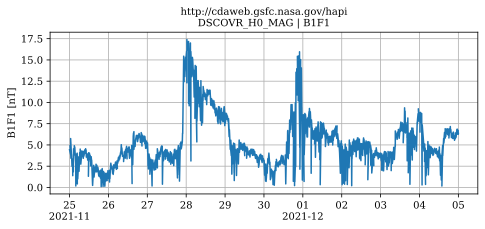

{'HAPI': '2.0',
 'status': {'code': 1200, 'message': 'OK'},
 'parameters': [{'name': 'Time',
   'type': 'isotime',
   'units': 'UTC',
   'length': 24,
   'fill': None},
  {'name': 'B1F1',
   'type': 'double',
   'units': 'nT',
   'fill': '-1.0E31',
   'description': 'Magnetic field magnitude (1 sec)',
   'hapiplot': {'figure': <Figure size 1008x432 with 1 Axes>}}],
 'startDate': '2015-06-08T00:00:00Z',
 'stopDate': '2022-02-19T23:59:59Z',
 'resourceURL': 'https://cdaweb.gsfc.nasa.gov/misc/NotesD.html#DSCOVR_H0_MAG',
 'contact': 'A. Koval @ UMBC, NASA/GSFC',
 'x_server': 'http://cdaweb.gsfc.nasa.gov/hapi',
 'x_dataset': 'DSCOVR_H0_MAG',
 'x_parameters': 'B1F1',
 'x_time.min': '2021-11-25T00:00:00Z',
 'x_time.max': '2021-12-05T00:00:00Z',
 'x_requestDate': '2022-04-25T16:46:28',
 'x_cacheDir': '/var/folders/pr/6xm0lrgx50g4276btj3p_dh00000gn/T/hapi-data/cdaweb.gsfc.nasa.gov_hapi',
 'x_downloadTime': 2.2112061977386475,
 'x_readTime': 0.02868509292602539,
 'x_metaFileParsed': '/var/folders

In [72]:
from hapiclient import hapi
from hapiplot import hapiplot

server     = 'http://cdaweb.gsfc.nasa.gov/hapi'
dataset    = 'DSCOVR_H0_MAG'
start      = '2021-11-25T00:00:00Z'
stop       = '2021-12-05T00:00:00Z'
parameters = 'B1F1'

opts       = {'logging': False}

# Get parameters
data, meta = hapi(server, dataset, parameters, start, stop, **opts)

# Plot all parameters in `data`
hapiplot(data, meta)

## Where is DSCOVR, anyway?

Often it is useful to know where a given spacecraft is. Coordinates are often available as a HAPI stream.  Here we get the DSCOVR position in GSE coordinates. And, for fun, the Moon's position as well. 

hapi(): Running hapi.py version 0.2.3
hapi(): file directory = cdaweb.gsfc.nasa.gov_hapi
hapi(): Reading DSCOVR_ORBIT_PRE_GSE_POS-MOON_GSE_POS_20211125T000000_20211205T000000.pkl
hapi(): Reading DSCOVR_ORBIT_PRE_GSE_POS-MOON_GSE_POS_20211125T000000_20211205T000000.npy 


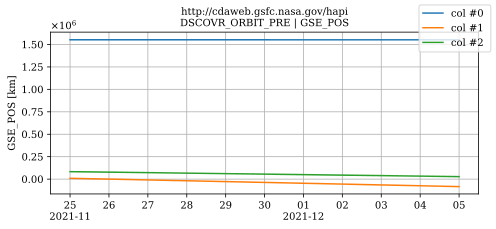

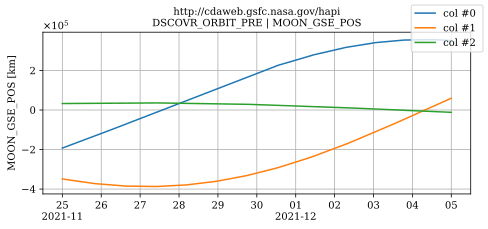

In [75]:
# note we are using the same times etc from previous calls
dataset    = 'DSCOVR_ORBIT_PRE'
parameters = 'GSE_POS,MOON_GSE_POS'

data, meta = hapi(server, dataset, parameters, start, stop, **opts)
hapiplot(data, meta);

### Parameter Order is Important!
To ensure that every HAPI query is identical, parameters MUST be requested in the order that their HAPI server's JSON description specifies.  For example, we queried for "GSE_POS, MOON_GSE_POS". If we switch the query order, we get a HAPI warning to correct that, as shown below. 

In [63]:
#parameters = 'GSE_POS,MOON_GSE_POS'
parameters = 'MOON_GSE_POS,GSE_POS'
data, meta = hapi(server, dataset, parameters, start, stop, **opts)

HAPIError: Parameter MOON_GSE_POS is not in meta


<div style="background-color:yellow">
<h3>Problem 01a</h3>

<p>The data service SSCWeb provides ephemeris data for most satellites. Starting with <a href="https://hapi-server.org/servers/">https://hapi-server.org/servers/</a>, see if you can find and plot the position of DISCOVR in your notebook in the code area below.</p>

</div>

In [74]:
from hapiclient import hapi
from hapiplot import hapiplot

start      = '2021-11-25T00:00:00Z'
stop       = '2021-12-05T00:00:00Z'
opts       = {'logging': True}

# Enter code here to obtain and plot position of DISCOVR during the following time interval.

Fortunately, as you can see above, the HAPI warning messages aim to be informative.

<div style="background-color:yellow">
<h3>Problem 01b</h3>
    
<p>Below are 4 other spacecraft datasets, with only the first not commented out.  Feel free to try all four by selectively un-commenting the <code>dataset</code> and <code>parameters</code> keywords.</p>

</h3>

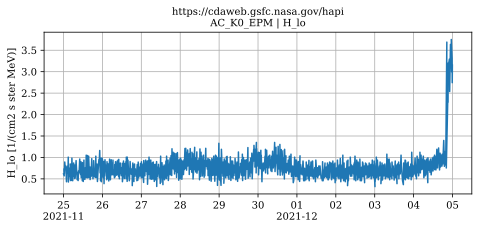

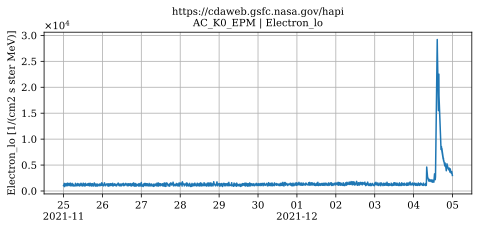

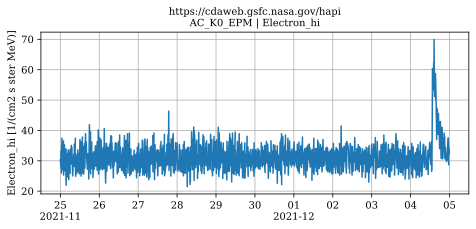

In [64]:
from hapiclient import hapi
from hapiplot import hapiplot

server     = 'https://cdaweb.gsfc.nasa.gov/hapi'
start      = '2021-11-25T00:00:00Z'
stop       = '2021-12-05T00:00:00Z'
opts       = {'logging': False}

## ACE Electron, Proton, and Alpha Monitor
##https://cdaweb.gsfc.nasa.gov/registry/hdp/hapi/hapiHtml.html#url=https://cdaweb.gsfc.nasa.gov/hapi&id=AC_K0_EPM
dataset    = 'AC_K0_EPM'
parameters = 'H_lo,Electron_lo,Electron_hi'

## POES N19 data: POES/MetOp: Particle Precipitation Data 
##https://cdaweb.gsfc.nasa.gov/registry/hdp/hapi/hapiHtml.html#url=https://cdaweb.gsfc.nasa.gov/hapi&id=NOAA15_POES-SEM2_FLUXES-2SEC
#dataset    = 'THB_L2_SST@1'
#parameters = 'thb_psef_densityQ'

## IMPACT(In-situ Measurements of Particles and CME Transients)/SIT data from the STEREO Ahead spacecraft.
##https://cdaweb.gsfc.nasa.gov/registry/hdp/hapi/hapiHtml.html#url=https://cdaweb.gsfc.nasa.gov/hapi&id=STA_L1_SIT
#dataset    = 'STA_L1_SIT'
#parameters = 'H_Intensity'

## Wind 3dp, EESA HIGH electron omni directional energy spectra
##https://cdaweb.gsfc.nasa.gov/registry/hdp/hapi/hapiHtml.html#url=https://cdaweb.gsfc.nasa.gov/hapi&id=WI_EHSP_3DP
#dataset    = 'WI_EHSP_3DP'
#parameters = 'FLUX'

data, meta = hapi(server, dataset, parameters, start, stop, **opts)
status=hapiplot(data, meta)

----
Next up, a look into the underlying data structures in [HAPI_02.ipynb](HAPI_02.ipynb)
----